In [1]:
import sys
from pathlib import Path

import torch
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "jupyterlab+png"

sys.path.append("../")
from src.utils import imbalance_ratio, plot_classification_dataset

In [2]:
DATASET_DIR = Path("../datasets")
CLASSIFICATION_DIR = DATASET_DIR / "classification"

In [3]:
datasets = {
    dataset_path.name: {
        split_path.stem: torch.load(split_path, map_location="cpu")
        for split_path in dataset_path.glob("*.pt")
    }
    for dataset_path in CLASSIFICATION_DIR.iterdir()
    if dataset_path.is_dir()
}

{dataset: list(datasets[dataset]) for dataset in datasets.keys()}

{'PenDigits': ['train', 'test'],
 'WISDM': ['train', 'val', 'test'],
 'FingerMovements': ['train', 'test'],
 'Epilepsy': ['train', 'val', 'test'],
 'HAR': ['train', 'val', 'test']}

In [4]:
{dataset: list(datasets[dataset]["train"].keys()) for dataset in datasets.keys()}

{'PenDigits': ['samples', 'labels'],
 'WISDM': ['samples', 'labels'],
 'FingerMovements': ['samples', 'labels'],
 'Epilepsy': ['samples', 'labels'],
 'HAR': ['samples', 'labels']}

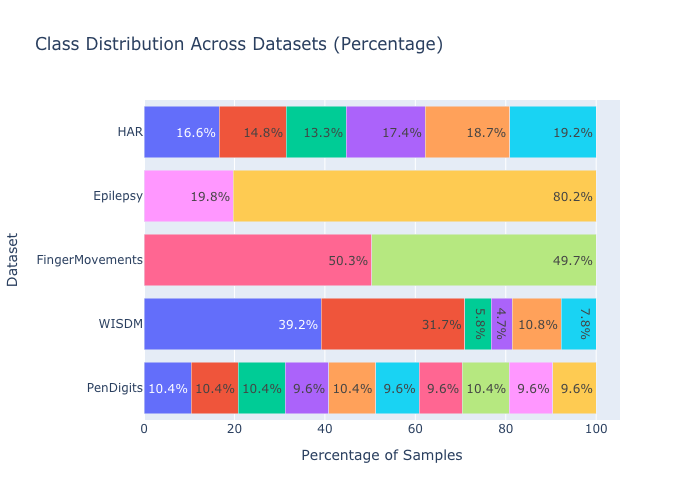

In [5]:
fig = go.Figure()

for dataset_name in datasets:
    labels = datasets[dataset_name]["train"]["labels"]
    unique_classes, class_counts = torch.unique(labels, return_counts=True)
    percentages = (class_counts / torch.sum(class_counts) * 100)
    
    for class_idx, (class_count, percentage) in enumerate(zip(class_counts, percentages)):
        fig.add_trace(go.Bar(
            y=[dataset_name],
            x=[percentage],
            name=f"Class {class_idx}",
            orientation="h",
            text=[f"{percentage:.1f}%"],
            hoverinfo="text+name",
        ))

fig.update_layout(
    title="Class Distribution Across Datasets (Percentage)",
    barmode="stack",
    xaxis_title="Percentage of Samples",
    yaxis_title="Dataset",
    showlegend=False
)
fig

In [6]:
df = pd.DataFrame(
    [
        (
            *dataset["train"]["samples"].shape,
            len(np.unique(dataset["train"]["labels"])),
            imbalance_ratio(dataset["train"]["labels"]),
        )
        for dataset in datasets.values()
    ],
    columns=["samples", "series_length", "variables", "num_classes", "imbalance_ratio"],
    index=datasets.keys(),
)

df

,samples,series_length,variables,num_classes,imbalance_ratio
PenDigits,7494,8,2,10,1.084840
WISDM,2617,256,3,6,8.418033
FingerMovements,316,50,28,2,1.012739
Epilepsy,7360,178,1,2,4.054945
HAR,5881,128,9,6,1.444872


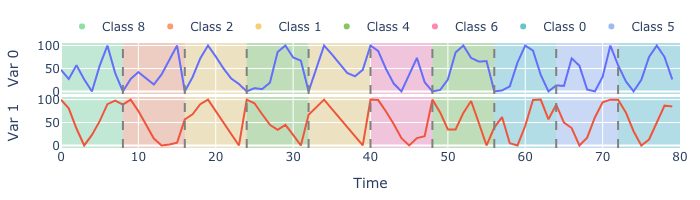

In [7]:
fig = plot_classification_dataset(
    datasets["PenDigits"]["train"]["samples"][:10, :].numpy(),
    datasets["PenDigits"]["train"]["labels"][:10].numpy(),
)
fig

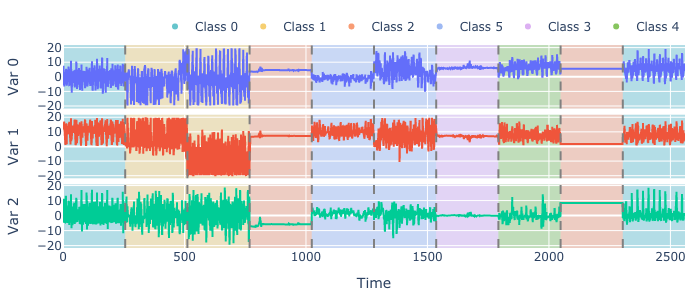

In [8]:
fig = plot_classification_dataset(
    datasets["WISDM"]["train"]["samples"][:10, :].numpy(),
    datasets["WISDM"]["train"]["labels"][:10].numpy(),
)
fig

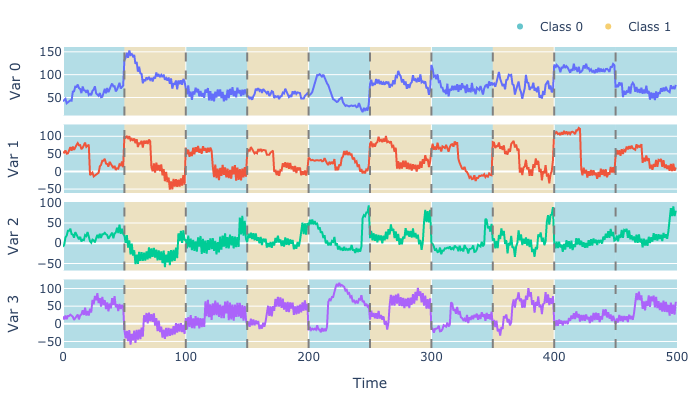

In [9]:
# Only the first 4 variables are plotted here since the whole dataset has 28
fig = plot_classification_dataset(
    datasets["FingerMovements"]["train"]["samples"][:10, :, :4].numpy(),
    datasets["FingerMovements"]["train"]["labels"][:10].numpy(),
)
fig

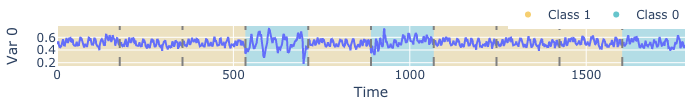

In [10]:
fig = plot_classification_dataset(
    datasets["Epilepsy"]["train"]["samples"][:10, :].numpy(),
    datasets["Epilepsy"]["train"]["labels"][:10].numpy(),
)
fig

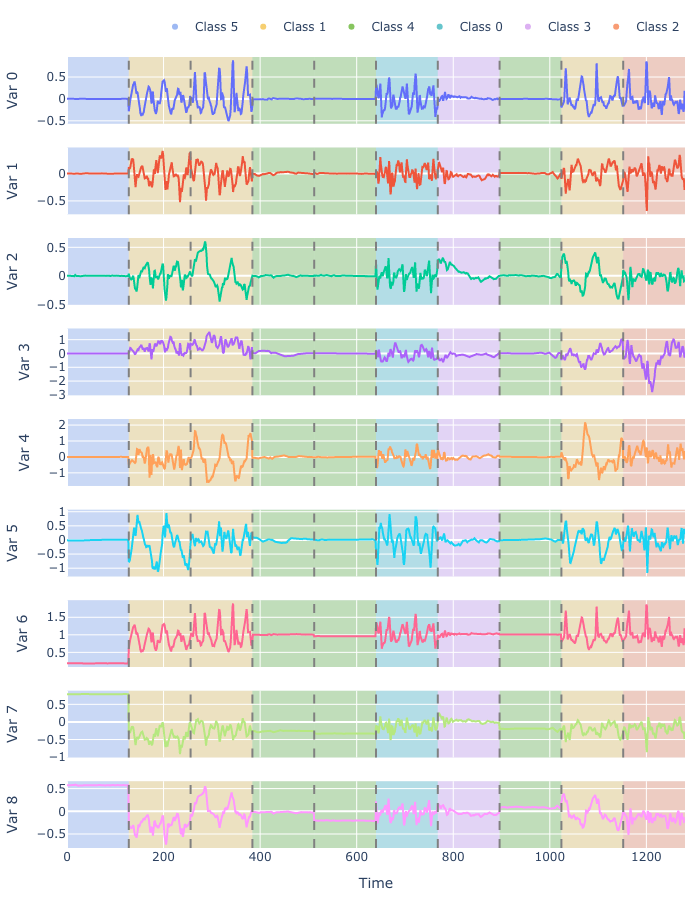

In [11]:
fig = plot_classification_dataset(
    datasets["HAR"]["train"]["samples"][:10, :].numpy(),
    datasets["HAR"]["train"]["labels"][:10].numpy(),
)
fig

### Datasets

1. **PenDigits Dataset** [[1]](https://archive.ics.uci.edu/dataset/81/pen+based+recognition+of+handwritten+digits)
    - The PenDigits (Pen-Based Recognition of Handwritten Digits) dataset is a
    classic dataset for handwritten digit recognition. It contains time series
    data representing the coordinates of pen movements as digits (0–9) are
    written on a digitizing tablet.
    - Collected from 44 writers, with 30 contributing to the training set (7,494
    samples) and 14 to the testing set (3,498 samples). Each writer wrote 250
    digits in random order using a WACOM tablet with 500x500 pixel resolution,
    normalized to a 100x100 scale.
    - Each digit is represented by 16 attributes
    (8 pairs of x, y coordinates), capturing the spatial trajectory of the pen
    over time. These are derived through spatial resampling of the pen's
    movement.

2. **WISDM Dataset** [[2]](https://archive.ics.uci.edu/dataset/507/wisdm+smartphone+and+smartwatch+activity+and+biometrics+dataset)
    - The WISDM (Wireless Sensor Data Mining) dataset focuses on human activity
    recognition (HAR) using sensor data from smartphones and smartwatches. It
    includes time series data from accelerometers and gyroscopes.
    - Controlled lab data from 36 users, with 1,098,207 samples collected at 20
    Hz using phone accelerometers. Activities include walking, jogging, sitting,
    standing, upstairs, and downstairs.
    - x, y, z acceleration or gyroscope readings

3. **FingerMovements Dataset** [[?]]()
    - The FingerMovements dataset is an EEG-based time series dataset capturing
    brain activity during finger movements, often used for brain-computer
    interface (BCI) research.
    - Don't know the exact details about the dataset since they vary by version.
    Requires more investigation.

4. **Epilepsy Dataset** [[?]]()
    - Similar to the above, includes EEG recordings used for seizure detection or prediction.

5. **HAR Dataset** [[3]](https://archive.ics.uci.edu/dataset/240/human+activity+recognition+using+smartphones)
    - The HAR (Human Activity Recognition) dataset typically refers to the UCI
    Human Activity Recognition Using Smartphones dataset, a widely used
    benchmark for activity classification.
    - Collected from 30 subjects performing 6 activities (walking, walking
    upstairs, walking downstairs, sitting, standing, lying) using a
    waist-mounted smartphone with accelerometer and gyroscope sensors. Data
    sampled at 50 Hz over 2.56-second windows.

### Toughts

The datasets are not normalized, TimeDRL uses instance normalization per sample:
$$X_{n,l,c} = \frac{X_{n,l,c} - \mu_{n,c}}{\sigma_{n,c}}$$ 
where $\mu_{n,c}$ and $\sigma_{n,c}$ are the mean and standard deviation across
time for each sample and channel.

This makes the model scale-invariant - adding a constant to a sample doesn't
change its normalized form. However, this may mask important scale differences
between patterns.

Have to look at the code to verify this!

---

Epilepsy and WISDM show notable class imbalance, making them ideal for studying
imbalanced learning. The other datasets are more balanced.
